In [173]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import statsmodels.api as sm
from statsmodels.formula.api import ols


In [174]:
df = pd.read_csv("C:spektr_dataset_060923.csv", low_memory=False, encoding='cp1251', delimiter=';')

In [175]:
df.head(3)

,project_id,reporting_month,well_id,layers,target_layer,Вид ГТМ,Согласование,Причина отклонения,группа причины отклонения,месторождение,...,Значение глинистой перемычки,Зачение текущей компенсации,Значение общей компенсации,Толщина нефтеносного слоя,"-1 - неизвестный источник, 0 - ТР, 1 - к",Актуальный статус скважины (во вре,ОИС ГТМ код указанный пользовател,"Целевой газовый фактор, куб.м/т",Целевой газовый фактор расчитан п,"Фактический режим, текущая частот.1"
0,3bbfd8dc-1aff-4cd2-9b64-89bfc87a76ad,2022-02-01,3340,ЮС2,ЮС2,4096,True,NaN,NaN,46,...,0.0,0.0,0.0,10.0,0,NaN,NaN,NaN,NaN,NaN
1,f0d5405a-ca8c-4cd4-8823-1ad2f3a0a916,2021-12-01,16845,БС12/1,БС12/1,2,False,Отсутствие эффекта от ГТМ по окружению,1.0,63,...,0.0,0.0,0.0,0.0,0,NaN,NaN,NaN,NaN,NaN
2,f0d5405a-ca8c-4cd4-8823-1ad2f3a0a916,2021-12-01,27456,БС12/1,БС12/1,2,False,Отсутствие эффекта от выбранной технологии ОПЗ...,1.0,63,...,0.0,0.0,0.0,0.0,0,NaN,NaN,NaN,NaN,NaN


In [176]:
df.columns.tolist()


['project_id',
 'reporting_month',
 'well_id',
 'layers',
 'target_layer',
 'Вид ГТМ',
 'Согласование',
 'Причина отклонения',
 'группа причины отклонения',
 'месторождение',
 'тип скважины',
 'срок действия причины отклонения',
 'Фактический режим \\ Дебит жидкости',
 'Фактический режим \\ Дебит нефти',
 'Фактический режим \\ Забойное давле',
 'Фактический режим \\ Пластовое давл',
 'Фактический режим \\ Текущий Кпрод',
 'Целевое забойное',
 'прирост по частоте',
 'Целевой режим \\ Целевой Кпрод',
 'Статический потенциал \\ Прирост де',
 'Статический потенциал \\ Прирост де.1',
 '[21] Динамический потенциал \\ Дополн',
 '[22] Динамический потенциал \\ Дополн',
 '[23] Динамический потенциал \\ Дополн',
 '[24] Экономическая эффективность \\ С',
 '[25] Экономическая эффективность \\ NP',
 '[26] Экономическая эффективность \\ PI',
 '[27] Экономическая эффективность \\ П',
 '[22] Динамический потенциал \\ Добыча',
 '[23] Динамический потенциал \\ Добыча',
 '[24] Динамический потенциал \\ Д

In [177]:
# в датафрейме содержатся данные за несколько лет, используем корректный метод для вычленения месяца, 
# иначе месяца разных годов могут стать одним месяцем
df['reporting_month'] = pd.to_datetime(df['reporting_month'], errors='coerce')
print(df['reporting_month'].dtype)



datetime64[ns]


##### Важные признаки для включения в модель? 'Фактический режим \ Дебит нефти', 'Статический потенциал \ Прирост дебита нефти', 'Целевой Qн'

##### 'Фактический режим \\ Дебит жидкости', выбросы. 22 NaN можно ли заполнять средним?

In [178]:
len(df[df['Фактический режим \ Дебит нефти'].isna()])

22

In [179]:
df.boxplot('Фактический режим \ Дебит нефти')

<Axes: >

In [180]:
df['Фактический режим \ Дебит нефти'].describe()

count    52113.000000
mean         6.440208
std         21.245474
min          0.000000
25%          0.000000
50%          0.000000
75%          5.547375
max        494.216640
Name: Фактический режим \ Дебит нефти, dtype: float64

##### 'Статический потенциал \ Прирост дебита нефти'. может ли быть отрицательным? выбросы? 11 NaN можно ли заполнять средним?

In [181]:
len(df[df['Статический потенциал \ Прирост де.1'].isna()])

11

In [182]:
df.boxplot('Статический потенциал \ Прирост де.1')

<Axes: >

In [183]:
df['Статический потенциал \ Прирост де.1'].describe()

count    52124.000000
mean         9.326430
std         40.179690
min       -248.590000
25%          2.536475
50%          4.624394
75%          8.404343
max       5696.535509
Name: Статический потенциал \ Прирост де.1, dtype: float64

##### 'Целевой Qн', выбросы, отрицательные значения. 11 NaN можно ли заполнять средним?

In [184]:
len(df[df['Целевой Qн'].isna()])

11

In [185]:
df.boxplot('Целевой Qн')

<Axes: >

In [186]:
df['Целевой Qн'].describe()

count    52124.000000
mean        15.598652
std         47.337860
min       -223.910000
25%          3.332943
50%          6.252744
75%         14.420314
max       5706.996741
Name: Целевой Qн, dtype: float64

##### Зависимость "Вид ГТМ", "Причина отклонения" от 'Фактический режим \\ Дебит нефти'

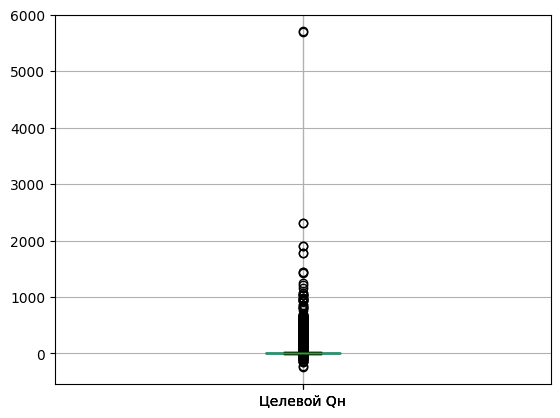

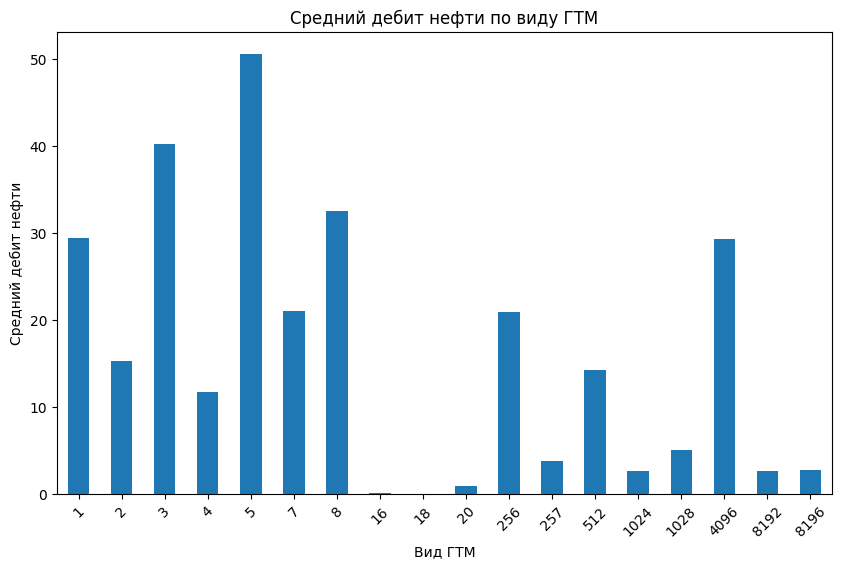

In [187]:
mean_debit_gtm = df.groupby('Вид ГТМ')['Фактический режим \\ Дебит нефти'].mean()
plt.figure(figsize=(10, 6))  #  размер графика 
mean_debit_gtm.plot(kind='bar')
plt.title('Средний дебит нефти по виду ГТМ')
plt.xlabel('Вид ГТМ')
plt.ylabel('Средний дебит нефти')
plt.xticks(rotation=45)  #  поворот меток по оси x для лучшей читаемости
plt.show()


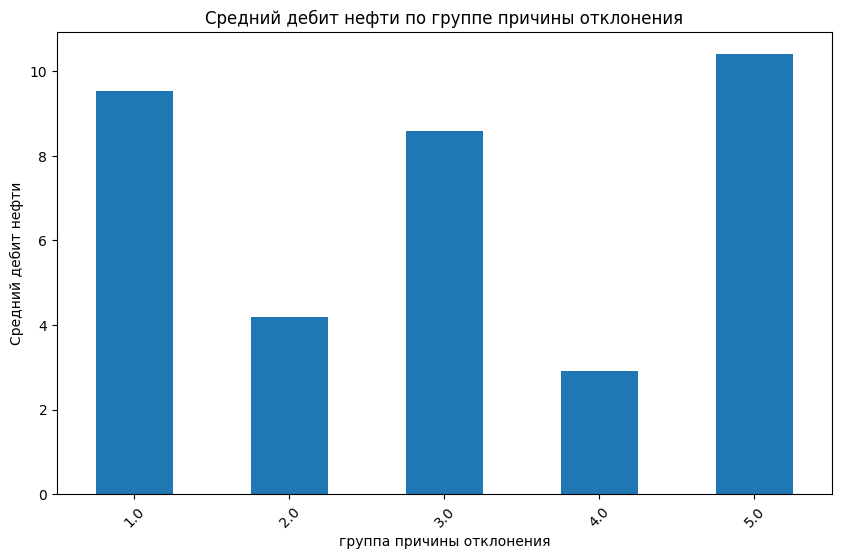

In [188]:
mean_debit_deviation = df.groupby('группа причины отклонения')['Фактический режим \\ Дебит нефти'].mean()
plt.figure(figsize=(10, 6))  # размер графика 
mean_debit_deviation.plot(kind='bar')
plt.title('Средний дебит нефти по группе причины отклонения')
plt.xlabel('группа причины отклонения')
plt.ylabel('Средний дебит нефти')
plt.xticks(rotation=45)  # поворот меток по оси x для лучшей читаемости
plt.show()


##### Каждая "Причина отклонения" имеет свою "Группу причин отклонения". Найдем значения которые покажут количество пропущенных значений в столбце "Фактический режим \ Дебит нефти" для каждой уникальной "Причины отклонения". Один из вариантов значения из "Фактический режим \ Дебит нефти" менять на средние значения по группе причин отклонения. Но в нашем случае мы их занулим.

In [189]:

# Создадим функцию для подсчета пропущенных значений
def count_missing(series):
    return series.isna().sum()

# Группировка данных по 'Причина отклонения' и применение функции count_missing к столбцу 'Фактический режим \\ Дебит нефти'
missing_counts = df.groupby('Причина отклонения')['Фактический режим \ Дебит нефти'].agg(count_missing)

print(missing_counts)

Причина отклонения
"Запирание" по инфраструктуре (жидкость/газ)                0
АВПД (аномально высокое пластовое давление)                 0
Аварийный фонд                                              0
Был ВСП по ЗП, КЛИН                                         0
Были остановки по ЗСП                                       0
                                                           ..
Увеличение частоты без эффекта                              0
Фонтанирование через затрубное пространство (Рзатр>Рлин)    0
Фонтанирует через затрубное пространство (Рзатр > Рлин)     0
ЧРФ                                                         0
Экономическая нецелесообразность                            4
Name: Фактический режим \ Дебит нефти, Length: 73, dtype: int64


In [190]:
def filling_missing_values(df, columns):
    for i in columns:
        df[i] = df[i].fillna(0)
    return df

columns = ['Фактический режим \ Дебит нефти', 'Фактический режим \ Дебит жидкости']
df_na = filling_missing_values(df, columns)
#columns_to_replace = df['Фактический режим \\ Дебит нефти', 'Фактический режим \\ Дебит жидкости']
#df = filling_missing_values(df, columns_to_replace)

In [191]:
df.groupby('тип скважины')['Фактический режим \ Забойное давле'].mean()

тип скважины
ВЕРТ    79.202301
ГОР     72.759325
Name: Фактический режим \ Забойное давле, dtype: float64

##### Заменим пропущенные значения в ['Фактический режим \ Забойное давле', 'Фактический режим \ Пластовое давл', 'Фактический режим \ Текущий Кпрод', 'Целевое забойное'] на средние.

In [192]:
def fill_missing_with_mean(df, columns_to_fill, column_for_grouping):

    # Вычисляем средние значения для каждой уникальной группы
    means = df.groupby(column_for_grouping)[columns_to_fill].transform('mean')
    
    # Заполняем пропущенные значения средними значениями
    df[columns_to_fill] = df[columns_to_fill].fillna(means)
    
    return df


# Список столбцов, в которых нужно заполнить пропущенные значения
columns_to_fill = ['Фактический режим \ Забойное давле', 'Фактический режим \ Пластовое давл', 'Фактический режим \ Текущий Кпрод', 'Целевое забойное']
column_for_grouping = 'месторождение'

# Заполняем пропущенные значения средними значениями для каждой группы 'тип скважины'
df = fill_missing_with_mean(df, columns_to_fill, column_for_grouping)



##### Заменим пропущенные значения в ['тип скважины'] на 'ВЕРТ' - вертикальный тип скважины

In [193]:
df['тип скважины'].fillna("ВЕРТ", inplace = True)


##### Пропущенные значения усредним по виду ГТМ
                                                 

In [194]:
def fill_missing_with_mean(df, columns_to_fill, column_for_grouping):

    # Вычисляем средние значения для каждой уникальной группы
    means = df.groupby(column_for_grouping)[columns_to_fill].transform('mean')
    
    # Заполняем пропущенные значения средними значениями
    df[columns_to_fill] = df[columns_to_fill].fillna(means)
    
    return df


# Список столбцов, в которых нужно заполнить пропущенные значения
columns_to_fill = ['[21] Динамический потенциал \ Дополн',
       '[22] Динамический потенциал \ Дополн',
       '[23] Динамический потенциал \ Дополн', '[22] Динамический потенциал \ Добыча',
       '[23] Динамический потенциал \ Добыча',
       '[24] Динамический потенциал \ Добыча', 'Целевой Qж', 'Целевой Qн']
column_for_grouping = 'Вид ГТМ'

# Заполняем пропущенные значения средними значениями для каждой группы 'тип скважины'
df = fill_missing_with_mean(df, columns_to_fill, column_for_grouping)

##### Пропущенные значения заменим на Среднее по target_layer

In [195]:
def fill_missing_with_mean(df, columns_to_fill, column_for_grouping):

    # Вычисляем средние значения для каждой уникальной группы
    means = df.groupby(column_for_grouping)[columns_to_fill].transform('mean')
    
    # Заполняем пропущенные значения средними значениями
    df[columns_to_fill] = df[columns_to_fill].fillna(means)
    
    return df


# Список столбцов, в которых нужно заполнить пропущенные значения
columns_to_fill = ['Линейное давление',
       'Плотность жидкости',
       'Диаметр э/к', 'Газ фактор',
       'Толщина нефтеносного слоя']
column_for_grouping = 'target_layer'

# Заполняем пропущенные значения средними значениями для каждой группы 'тип скважины'
df = fill_missing_with_mean(df, columns_to_fill, column_for_grouping)

##### Пропущенные в target_layer заменим на текущие по layers

In [196]:
df['target_layer'].fillna(df["layers"], inplace = True)

##### Пропущенные в ['Статический потенциал \ Прирост дебита жидкости', 'Статический потенциал \ Прирост дебита жидкости'] заменим на Разницу между целевым и фактическим

In [197]:
df['Статический потенциал \ Прирост де'].fillna(df['Целевой Qж'] - df['Фактический режим \ Дебит жидкости'], inplace = True)
df['Статический потенциал \ Прирост де.1'].fillna(df['Целевой Qж'] - df['Фактический режим \ Дебит нефти'], inplace = True)

##### Пропущенные в ['Целевая обводненность'] заменим на рассчитанные по формуле: Целевая Обводненность = 1 - (целевой Qн/плотность нефти)/целевой Qж

In [198]:
df['Целевая обводненность'].fillna(1- (df['Целевой Qн'] / df['Плотность нефти'] / df['Целевой Qж']), inplace = True)

##### Пропуски меняем на среднее

In [199]:
def filling_missing_values(df, columns_to_fill):
    return df.fillna(df[columns_to_fill].mean())

columns_to_fill = ['[99] Время до псевдо установившегос', 'Обводнённость', 'Удлиннение', 'Верхний предел перфорации',
                   'Целевой дебит газа','Фактический режим, текущая частот', 'Зачение текущей компенсации', 'Значение общей компенсации','Толщина нефтеносного слоя','Доп. добыча жидкости','Доп. добыча нефти']
df = filling_missing_values(df, columns_to_fill)

##### Оставшиеся признаки имеет слишком много пропуском, поэтому дальше в расчетах они не участвуют

In [200]:
def filling_missing_values(df):
    return df.dropna(axis=1, how='any')
    
df = filling_missing_values(df)

#####  Прогнозируем поле Согласование. По тем мероприятиям, по которым получили статус согласования false - определяем Причину отклонения.

In [201]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
import numpy as np

In [202]:
df['reporting_month'] = df['reporting_month'].dt.strftime('%Y-%m-%d')
df['Согласование'] = df['Согласование'].astype(int)
df['Прочий фонд'] = df['Прочий фонд'].astype(int)


In [203]:
#df['reporting_month'] = df['reporting_month'].values.astype('float64')

In [204]:

def find_categorical_columns(df):
    categorical_columns = df.select_dtypes(include=['object', 'category']).columns
    return categorical_columns


categorical_columns = find_categorical_columns(df)
print("Категориальные столбцы:", categorical_columns)


Категориальные столбцы: Index(['project_id', 'reporting_month', 'layers', 'target_layer',
       'тип скважины'],
      dtype='object')


In [205]:
from sklearn.preprocessing import LabelEncoder

# Создайте экземпляры LabelEncoder для каждого столбца
label_encoders = {}

columns_to_encode = ['project_id', 'layers', "target_layer", "тип скважины", 'reporting_month']

for i in columns_to_encode:
    label_encoders[i] = LabelEncoder()
    df[i] = label_encoders[i].fit_transform(df[i])



In [206]:
df.head()

,project_id,reporting_month,well_id,layers,target_layer,Вид ГТМ,Согласование,месторождение,тип скважины,срок действия причины отклонения,...,Показатель FCF от доп. добычи,Показатель FCF от доп. добычи (сколь,Целевой дебит газа,"Фактический режим, текущая частот",Газ фактор,Значение глинистой перемычки,Зачение текущей компенсации,Значение общей компенсации,Толщина нефтеносного слоя,"-1 - неизвестный источник, 0 - ТР, 1 - к"
0,49,17,3340,551,554,4096,1,46,1,0,...,169.165973,28.098698,2.448224,50.0,67.002477,0.0,0.00000,0.000000,10.0,0
1,233,15,16845,386,386,2,0,63,1,65,...,0.000000,0.000000,0.621427,162.9,51.000000,0.0,0.00000,0.000000,0.0,0
2,233,15,27456,386,386,2,0,63,1,494,...,0.000000,0.000000,0.767778,55.0,51.000000,0.0,0.00000,0.000000,0.0,0
3,193,16,12728,291,293,2,1,133,0,0,...,4.279195,0.088976,0.158988,201.6,32.709936,0.0,1.63323,0.461137,0.0,0
4,233,15,10682,323,325,2,0,30,1,494,...,0.000000,0.000000,1.672289,49.7,124.000000,0.0,0.00000,0.000000,0.0,0


In [207]:
#from sklearn.preprocessing import StandardScaler

#scaler = StandardScaler()
#df['Зачение текущей компенсации'] = scaler.fit_transform(df['Зачение текущей компенсации'].values.reshape(-1, 1))
#df['Значение общей компенсации'] = scaler.fit_transform(df['Значение общей компенсации'].values.reshape(-1, 1))


In [208]:
import numpy as np

# Замените положительную бесконечность на 0 в столбце 'feature'
df.loc[np.isposinf(df['Зачение текущей компенсации']), 'Зачение текущей компенсации'] = 0

# Замените положительную бесконечность на 0 в столбце 'feature'
df.loc[np.isposinf(df['Значение общей компенсации']), 'Значение общей компенсации'] = 0

In [209]:
df.head()

,project_id,reporting_month,well_id,layers,target_layer,Вид ГТМ,Согласование,месторождение,тип скважины,срок действия причины отклонения,...,Показатель FCF от доп. добычи,Показатель FCF от доп. добычи (сколь,Целевой дебит газа,"Фактический режим, текущая частот",Газ фактор,Значение глинистой перемычки,Зачение текущей компенсации,Значение общей компенсации,Толщина нефтеносного слоя,"-1 - неизвестный источник, 0 - ТР, 1 - к"
0,49,17,3340,551,554,4096,1,46,1,0,...,169.165973,28.098698,2.448224,50.0,67.002477,0.0,0.00000,0.000000,10.0,0
1,233,15,16845,386,386,2,0,63,1,65,...,0.000000,0.000000,0.621427,162.9,51.000000,0.0,0.00000,0.000000,0.0,0
2,233,15,27456,386,386,2,0,63,1,494,...,0.000000,0.000000,0.767778,55.0,51.000000,0.0,0.00000,0.000000,0.0,0
3,193,16,12728,291,293,2,1,133,0,0,...,4.279195,0.088976,0.158988,201.6,32.709936,0.0,1.63323,0.461137,0.0,0
4,233,15,10682,323,325,2,0,30,1,494,...,0.000000,0.000000,1.672289,49.7,124.000000,0.0,0.00000,0.000000,0.0,0


In [210]:
#np.isinf(df).sum()

In [211]:
#from sklearn.preprocessing import StandardScaler

#scaler = StandardScaler()
#df_scaled= scaler.fit_transform(df)


In [212]:
# Преобразовать массив NumPy в DataFrame
#df_scaled = pd.DataFrame(df_scaled, columns=df.columns)

In [213]:
X = df.drop('Согласование', axis = 1)
y = df['Согласование']

In [214]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

C:\Users\rusta\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [215]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.3f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.932


In [216]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[8883  824]
 [ 240 5694]]


In [217]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.92      0.94      9707
           1       0.87      0.96      0.91      5934

    accuracy                           0.93     15641
   macro avg       0.92      0.94      0.93     15641
weighted avg       0.94      0.93      0.93     15641



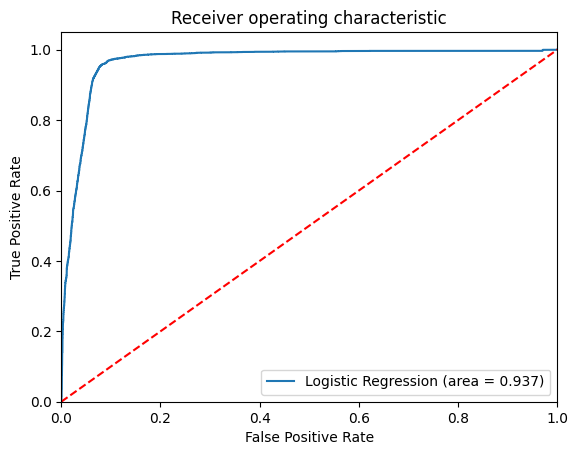

In [218]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.3f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [219]:
# Оценка важности признаков
feature_importance = abs(logreg.coef_[0])

# Сортировка признаков по их важности
sorted_feature_importance = sorted(zip(feature_importance, X.columns), reverse=True)

# Вывод наиболее важных признаков
for importance, feature in sorted_feature_importance:
    print(f"Feature: {feature}, Importance: {importance}")

Feature: срок действия причины отклонения, Importance: 0.07728105563920667
Feature: Вид ГТМ, Importance: 0.011624451404032857
Feature: Целевая обводненность, Importance: 0.008546085143725563
Feature: [22] Динамический потенциал \ Дополн, Importance: 0.0047261036922392865
Feature: Показатель FCF ГТМ (скользящий год), Importance: 0.003594275957877955
Feature: Целевой Qн, Importance: 0.003461189701630342
Feature: Обводнённость, Importance: 0.0033918990381384467
Feature: Показатель FCF от доп. добычи (сколь, Importance: 0.003246572161424662
Feature: [23] Динамический потенциал \ Добыча, Importance: 0.00301545595414018
Feature: Целевой Qж, Importance: 0.0029532391714752024
Feature: project_id, Importance: 0.0029194700392688204
Feature: Целевое забойное, Importance: 0.0023361646768624146
Feature: Статический потенциал \ Прирост де.1, Importance: 0.002060821311629495
Feature: ГЭП база, Importance: 0.002045100947289769
Feature: Доп. добыча нефти, Importance: 0.0019721346126749147
Feature: Целе

In [220]:

import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve, validation_curve

# Задайте диапазон размеров обучающего набора
train_sizes = np.linspace(0.1, 1.0, 10)

# Постройте кривую обучения
train_sizes, train_scores, test_scores = learning_curve(
    LogisticRegression(), X, y, train_sizes=train_sizes, cv=5)

# Вычислите средние значения и стандартные отклонения оценок
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Постройте кривую обучения
plt.figure()
plt.title("Learning Curve Log. Reg.")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.grid()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.legend(loc="best")

# Постройте кривую валидации
param_range = np.logspace(-6, 3, 12)
train_scores, test_scores = validation_curve(
    LogisticRegression(), X, y, param_name="C", param_range=param_range, cv=5)

# Вычислите средние значения и стандартные отклонения оценок
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)


plt.show()  


C:\Users\rusta\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\rusta\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stab

KeyboardInterrupt: 

C:\Users\rusta\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\rusta\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stab

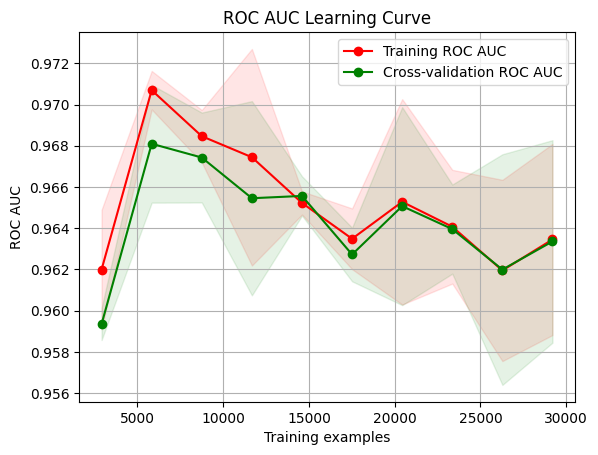

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

'''  Как меняется ROC AUC в зависимости от размера тренировочной выборки поможет вам оценить, как модель проявляет себя на тренировочных и кросс-валидационных наборах данных при разных размерах тренировочной выборки. 
Если красная и зеленая кривые сходятся и имеют высокие значения, это хороший признак того, что модель работает хорошо на обучающих и тестовых данных.'''


# Задайте модель (логистическую регрессию или другую) и обучающие данные (X_train, y_train)
logreg = LogisticRegression(C=0.05)
train_sizes, train_scores, test_scores = learning_curve(logreg, X_train, y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=5, scoring='roc_auc')

#  средние значения и стандартные отклонения ROC AUC на обучающем и тестовом наборах
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

#  кривую обучения для ROC AUC
plt.figure()
plt.title("ROC AUC Learning Curve")
plt.xlabel("Training examples")
plt.ylabel("ROC AUC")
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")

plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training ROC AUC")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation ROC AUC")

plt.legend(loc="best")
plt.show()


In [ ]:
''' from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Разбейте данные на тренировочный и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Создайте модель случайного леса
rf_model = RandomForestClassifier(n_estimators=50, max_depth = 4, random_state=12345)

# Обучите модель на тренировочных данных
rf_model.fit(X_train, y_train)

# Сделайте прогноз на тестовых данных
y_pred = rf_model.predict(X_test)

# Оцените производительность модели (например, точность)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}') '''


Accuracy: 0.96


In [221]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score


# Создайте модель случайного леса
rf_model = RandomForestClassifier(n_estimators=50, max_depth = 5, random_state=0)

# Выполните кросс-валидацию
scores = cross_val_score(rf_model, X, y, cv=5)  # cv - количество фолдов

# Выведите среднюю оценку точности на каждом фолде
print("Cross-Validation Scores:", scores)
print("Mean Accuracy:", scores.mean())


Cross-Validation Scores: [0.98724465 0.96988587 0.99587609 0.96863911 0.87743359]
Mean Accuracy: 0.959815862664237


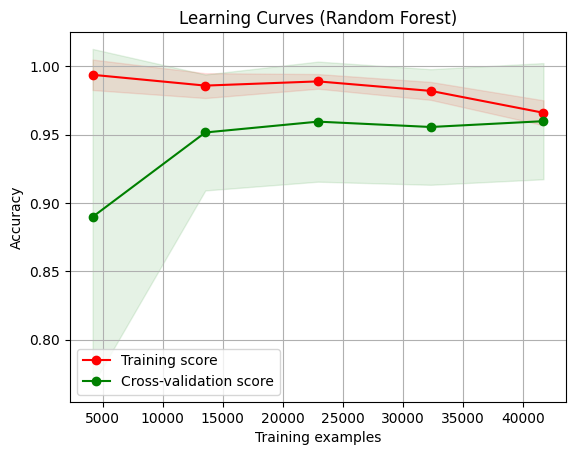

'кривая обучения. Видим, что производительность на валидационных данных слабо улучшается при увеличении размера выборки, это может быть признаком переобучения. '

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, cv, train_sizes):
    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Accuracy")
    
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, train_sizes=train_sizes, scoring='accuracy')
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# Пример использования:
title = "Learning Curves (Random Forest)"
cv = 5  # Количество фолдов в кросс-валидации
train_sizes = np.linspace(.1, 1.0, 5)  # Размеры тренировочного набора данных

plot_learning_curve(rf_model, title, X, y, cv, train_sizes)
plt.show()


'''кривая обучения. Видим, что производительность на валидационных данных слабо улучшается при увеличении размера выборки, это может быть признаком переобучения. '''

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Создайте модель случайного леса
rf = RandomForestClassifier()

# Обучите модель на вашем тренировочном наборе данных
rf.fit(X_train, y_train)

# Получите важности признаков
feature_importances = rf.feature_importances_

# Создайте DataFrame для удобного отображения результатов
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

# Отсортируйте признаки по их важности
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Выведите результаты
print(importance_df)


                                     Feature  Importance
8           срок действия причины отклонения    0.633254
1                            reporting_month    0.033690
31                                Целевой Qн    0.021566
23       [99] Время до псевдо установившегос    0.015429
15      Статический потенциал \ Прирост де.1    0.014368
32                     Целевая обводненность    0.013138
28                        Давление насыщения    0.013096
13                          Целевое забойное    0.012309
27                 Верхний предел перфорации    0.010945
43                        Целевой дебит газа    0.010492
12         Фактический режим \ Текущий Кпрод    0.010410
39      Показатель FCF база (скользящий год)    0.009942
14        Статический потенциал \ Прирост де    0.009519
30                                Целевой Qж    0.008572
41             Показатель FCF от доп. добычи    0.008553
2                                    well_id    0.008180
18      [23] Динамический потен

In [ ]:
df['срок действия причины отклонения'].head()

0      0
1     65
2    494
3      0
4    494
Name: срок действия причины отклонения, dtype: int64